<h1> Running Markov Chain Monte Carlo Simulations (MCMCs) and <br/>Analysing Their Output </h1>

<h2> Motivating Example: Quadratic Regression </h2>

<p>
Let's say that you are measuring the levels of receptor Y at the cell surface as a function of concentration of drug X. Receptor Y expression is measured using fluorescent anti-hIgG antibody bound to anti-receptor-Y antibody. The relationship looks roudhly quadratic, and so you wish to model the relationship using a quadratic function. <br/> <br/>
The data is artificially generated below.
<p>

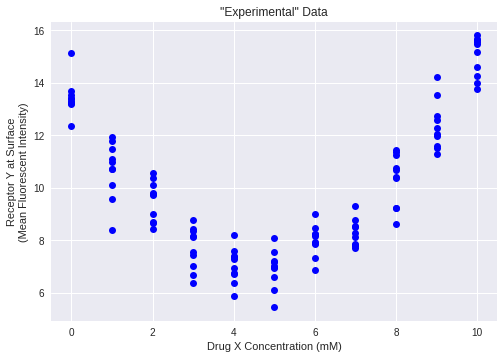

In [57]:
import numpy as np

### Define function for "experimental" data generation
# Paramters for "actual" quadratic function
a = 0.27
b = -2.5
c = 13.0

gen = np.vectorize(lambda x: a*x**2+b*x+c)
x = np.arange(0.0,11.0)
y = gen(x)

# Standard deviation of noise; noise will be normally distributed
sig = 1.0

# Create measurements
meas = y + sig*np.random.randn(10,11)

### Show experimental data
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('figure', figsize=(8.0,5.5))

ax = plt.gca()
for row in meas:
    ax.plot(x, row, marker='o', color='blue', linestyle='none')
    ax.set_title('"Experimental" Data')
    ax.set_xlabel('Drug X Concentration (mM)')
    ax.set_ylabel('Receptor Y at Surface\n(Mean Fluorescent Intensity)')

plt.show()

In [58]:
### Store experimental data into importable file
meas.dump('elisa_measurement.npy')

<h2> Affine-Invariant MCMC: a Non-Hamiltonian MCMC </h2>

<p>
Using the affine-invariant sampler from the package <a href="http://dan.iel.fm/emcee/current/">emcee</a>. Most MCMCs consist of a single "walker" roaming around the state space, traveling with points with higher likelihood more often than those with lower log-likelihood. This affine-invariant sampler, instead of running a single-walker Markoc chain, consists of a Markov chain of multiple walkers roaming around the state-space together. This requires calculating as many log-likelihoods per iteration as there are walkers, which makes the algorithm's run time per iteration scale linearly with the number of walkers. That being said, this is a good MCMC for traveling around converged Markov-chain distributions that are very long and narrow\*\*\*, or that otherwise have a lot of pockets of significant probability density\*. While this MCMC's runtime per iteration scales linearly with number of walkers and number of parameters, the number of iterations it takes for its Markov chain to converge to its stationary distribution scales exponentially with number of parameters in the state-space\*\*. <br/> <br/>

\* For this latter point about "pockets of significant density", there exist non-Hamiltonian MCMCs that are sometimes better, like emcee's parallel-tempered MCMC. <br/> <br/>

\*\* Most MCMCs scale exponentially with the number of parameters in the state-space. This is generally true for all MCMCs that do not calculate the next point in the Markov chain using gradient methods. <br/> <br/>

\*\*\* Below is an example of a converged Markov chain distribution that is long (on the x-axis) and narrow (on the y-axis) <br/> <br/>

<a href="http://dan.iel.fm/emcee/current/user/quickstart/">Here</a> is a quickstart guide for emcee's affine-invariant sampler. Note that I use the affine-invariant sampler here not because it is particularly powerful or easy to use, but because it is the implementation of non-Hamiltonian MCMC with which I am most familiar. The packages PyMC3 and <a href="http://fb09-pasig.umwelt.uni-giessen.de/spotpy/">spotpy</a> are well-documented and implement reputable MCMC samplers. PyMC3 is better known and better documented.
</p>

In [59]:
### Prepare for MCMC
# Load in experimental data
elisa_meas = np.load('elisa_measurement.npy')

def quad(a, b, c):
    return lambda x: a*x**2+b*x+c

# Normal distribution function. Sums over the log-likelihoods of points in x.
def logpdf_sum(x, loc, scale):
    root2 = np.sqrt(2)
    root2pi = np.sqrt(2 * np.pi)
    prefactor = - x.size * np.log(scale * root2pi)
    summand = -np.square((x - loc) / (root2 * scale))
    return prefactor + np.sum(summand)

# Define hyperbolic tangent transform to keep the common logarithm of the standard deviation parameter 
# between -5 and 5
tanh_trans = lambda x: (10.0*np.tanh(x)+1.0)/2.0-5.0

# Define log-likelihood function
def loglike(xx):
    # xx[0] is the quadratic coefficient
    # xx[1] is the linear coefficient
    # xx[2] is the constant term
    # xx[3] is the common log (log_10) of the standard deviation of the model noise. 
    # Because the standard deviation is necessarily positive, we put 10 to the power of 
    # xx[3], after the tanh transform (see above) to ensure that we never have a negative 
    # standard deviation.
    xx[3] = 10**tanh_trans(xx[3])

    test_quad = quad(xx[0], xx[1], xx[2])

    # Likelihoods of independent events happening concurrently compound multiplicatively; log-likelihoods,
    # therefore, compound additively. Here, we iterate over the experimental data for each concentration of drug X.
    loglike = 0.0
    for j in range(elisa_meas.shape[1]):
        loglike += logpdf_sum(elisa_meas[:,j], test_quad(float(j)), xx[3])
    if np.isnan(loglike):
        return -np.inf
    else:
        return loglike

# Initialize sampler
from emcee import EnsembleSampler as ens
nwalkers = 12
ndims = 4
sampler = ens(nwalkers=nwalkers, dim=ndims, lnpostfn=loglike)

In [60]:
### Set up function for storing MCMC chain in .h5 file
def startH5File(filename, dim):
    import h5py
    f = h5py.File(filename, 'w', libver='latest')
    dset = f.create_dataset("data",
                            chunks=True,
                            maxshape=(None, dim + 2),
                            data=np.ndarray((0, dim + 2)))
    f.swmr_mode = True
    return (f, dset)

In [61]:
### Run an MCMC simulation for an INSUFFICIENT number of iterations; meant to demonstrate the property of
### convergence
# Initialize .h5 file
try:
    (f, dset) = startH5File(filename="dummy_chain.h5", dim=4)
except OSError:
    f.close()
    (f, dset) = startH5File(filename="dummy_chain.h5", dim=4)
    
# Initialize all walkers near the point (0.0, -1.0, 10.0, 1.0)
# p0 = np.tile(np.array([0.0, -1.0, 10.0, 1.0]), (nwalkers,1)) + np.random.rand(nwalkers,ndims)
p0 = np.zeros((nwalkers,ndims)) + np.random.randn(nwalkers,ndims)

# Run sampler for 1000 iterations; should take about five minutes 
from time import time
counter = 0
start = time()
for p, lnprob, _ in sampler.sample(p0, iterations=1000, storechain=False):
    counter += 1
    if counter % 200 == 0:
        print(str(counter)+' iterations done in '+str(time()-start)+' seconds.')
    matOut = np.concatenate((lnprob.reshape(nwalkers, 1), np.arange(0, nwalkers).reshape(nwalkers, 1), p.reshape(nwalkers, ndims)), axis=1)
    fShape = dset.shape
    dset.resize((fShape[0] + np.shape(matOut)[0], fShape[1]))
    dset[fShape[0]:, :] = matOut
    f.flush()
print('Finished sampling.')

200 iterations done in 0.6417887210845947 seconds.
400 iterations done in 1.2634828090667725 seconds.
600 iterations done in 1.8904993534088135 seconds.
800 iterations done in 2.5378620624542236 seconds.
1000 iterations done in 3.1739389896392822 seconds.
Finished sampling.


In [62]:
### Run an MCMC simulation for a SUFFICIENT number of iterations
# Initialize .h5 file
try:
    (f, dset) = startH5File(filename="mcmc_chain.h5", dim=4)
except OSError:
    f.close()
    (f, dset) = startH5File(filename="mcmc_chain.h5", dim=4)
    
# Initialize all walkers near the point (0.0, -1.0, 10.0, 1.0)
# p0 = np.tile(np.array([0.0, -1.0, 10.0, 1.0]), (nwalkers,1)) + np.random.rand(nwalkers,ndims)
p0 = np.zeros((nwalkers,ndims)) + np.random.randn(nwalkers,ndims)

# Run sampler for 100000 iterations; should take about five minutes 
from time import time
counter = 0
start = time()
for p, lnprob, _ in sampler.sample(p0, iterations=100000, storechain=False):
    counter += 1
    if counter % 5000 == 0:
        print(str(counter)+' iterations done in '+str(time()-start)+' seconds.')
    matOut = np.concatenate((lnprob.reshape(nwalkers, 1), np.arange(0, nwalkers).reshape(nwalkers, 1), p.reshape(nwalkers, ndims)), axis=1)
    fShape = dset.shape
    dset.resize((fShape[0] + np.shape(matOut)[0], fShape[1]))
    dset[fShape[0]:, :] = matOut
    f.flush()
print('Finished sampling.')

5000 iterations done in 16.221603631973267 seconds.
10000 iterations done in 31.65043568611145 seconds.
15000 iterations done in 48.92652177810669 seconds.
20000 iterations done in 67.41585564613342 seconds.
25000 iterations done in 83.75630307197571 seconds.
30000 iterations done in 99.68392610549927 seconds.
35000 iterations done in 115.57382035255432 seconds.
40000 iterations done in 131.55998134613037 seconds.
45000 iterations done in 147.63695096969604 seconds.
50000 iterations done in 163.8986780643463 seconds.
55000 iterations done in 180.01804733276367 seconds.
60000 iterations done in 196.61248898506165 seconds.
65000 iterations done in 213.08196640014648 seconds.
70000 iterations done in 230.36258053779602 seconds.
75000 iterations done in 246.04071521759033 seconds.
80000 iterations done in 261.09417057037354 seconds.
85000 iterations done in 276.17325830459595 seconds.
90000 iterations done in 289.43786573410034 seconds.
95000 iterations done in 302.71815943717957 seconds.


<h2> Assaying the Convergence of an MCMC Chain </h2>

<h3> Visualizing MCMC Output </h3>

<p>
As far as I've seen and read, the most popular Python graphing packages used for scientific publications are the packages <a href="http://matplotlib.org/index.html">matplotlib</a> and <a href="http://seaborn.pydata.org/index.html">seaborn</a>. seaborn is built off of matplotlib; that is, seaborn is essentially a software that is meant to create manipulate matplotlib objects in a way that results in more aesthetically-pleasing and easily-generate figures than would be feasible with most basic matplotlib functions. <br/> <br/>

Note that seaborn automatically changes default matplotlib parameters upon importation. This becomes a problem when trying to use matplotlib line-art characters.
</p>

In [63]:
### Read in MCMC data
import pandas as pd
import h5py

# Open hdf5 files
f = h5py.File('mcmc_chain.h5', 'r')
g = h5py.File('dummy_chain.h5', 'r')

# Create pointer to main data set
dset = f['/data']
dummy_dset = g['/data']

if dset is None:
    raise AssertionError("Dataset from mcmc_chain.h5 was read as empty.")
if dummy_dset is None:
    raise AssertionError("Dataset from dummy_chain.h5 was read as empty.")


cNames = ['LL', 'walker', 'a', 'b', 'c', 'logsig']

# Read in dataset to Pandas frame
pdset = pd.DataFrame(dset.value, columns=cNames)
dummy_pdset = pd.DataFrame(dummy_dset.value, columns=cNames)

f.close()
g.close()

<h3> Convergence and Burn-In </h3>

<p>
See the differences in parameter spread between the high-iteration (appropriate) chain and the low-iteration (inappropriate) chain. If an MCMC is not allowed to run for many iterations, it will not approximate the model's probability density over its state-space.
</p>

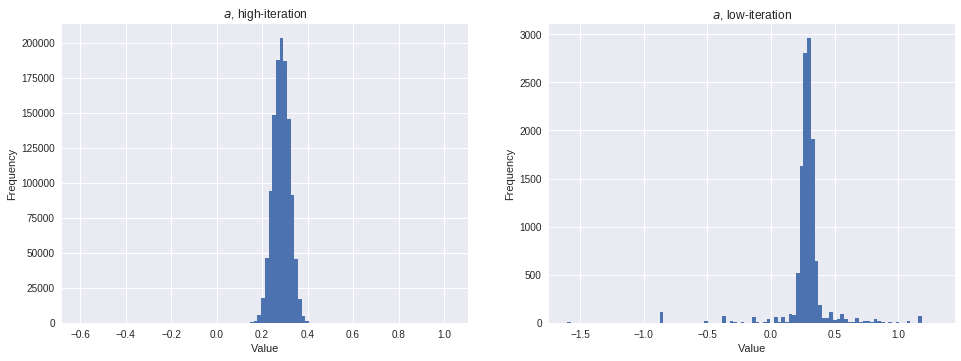

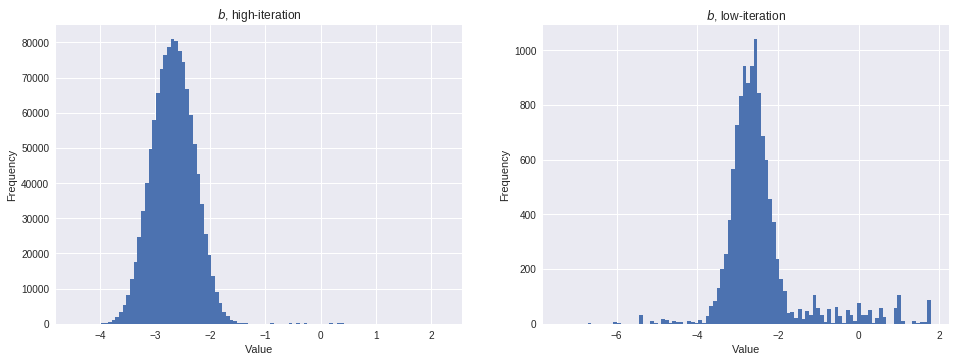

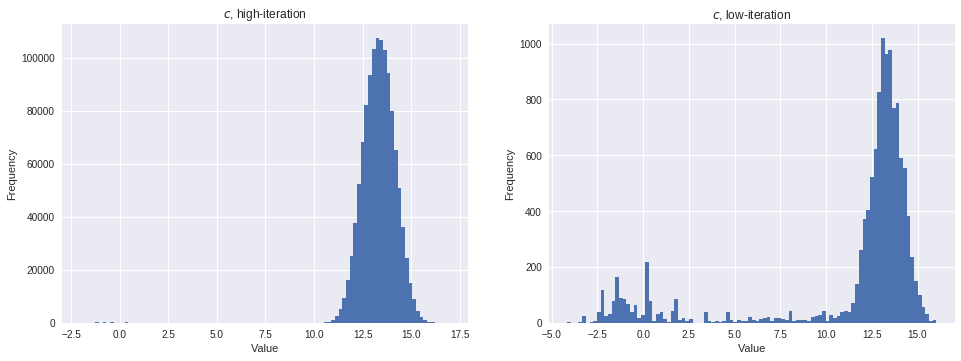

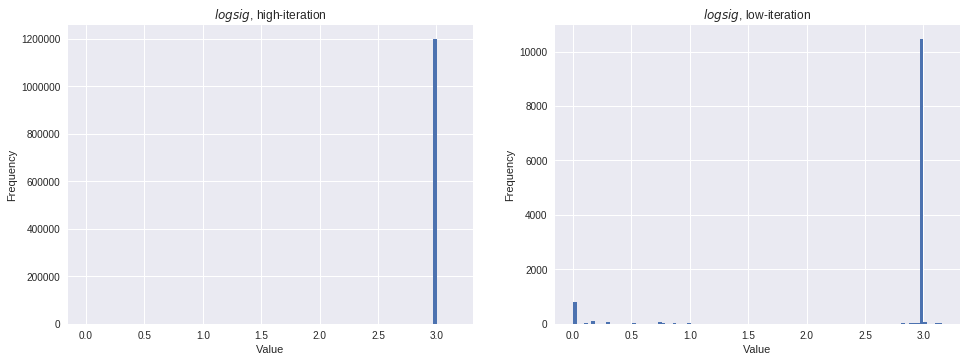

In [64]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=False)
rc('figure', figsize=(16,5.5))
import seaborn as sns

# Number of bins for histogram
nbins = 100

# Get list parameter names
params = [col for col in pdset.columns if col not in ['LL', 'walker']]

# Plot histograms
for par in params:
    f = plt.figure()
    ax_good = f.add_subplot(121)
    ax_dummy = f.add_subplot(122)
    for ax, which, df in zip([ax_good, ax_dummy], ['high-iteration', 'low-iteration'], [pdset, dummy_pdset]):
        ax.hist(df[par], bins=nbins)
        ax.set_title(eval('r"$'+par+'$, '+which+'"'))
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    
plt.show()

<h3> Convergence and Burn-In (cont.) </h3>

<p>
Also, note that, when not starting MCMC walkers near the point of highest likelihood in the state space causes the first part of the chain to not be representative of the probability density function over the state-space. This is why <a href="http://users.stat.umn.edu/~geyer/mcmc/burn.html">burn-in</a>\*, or any method that effectively implements burn-in, is necessary. The following makes histograms of the high-iteration chains after "burning" 20,000 iterations from the beginning of the MCMC. <br/> <br/>

\* Note that the linked article talks about burn-in in a negative light. This is to emphasize that burn-in is a method of implementing something that can otherwise be implemented.
</p>

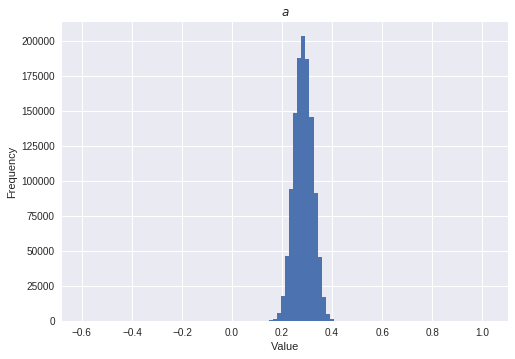

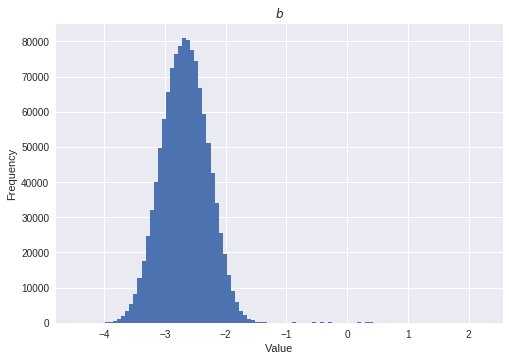

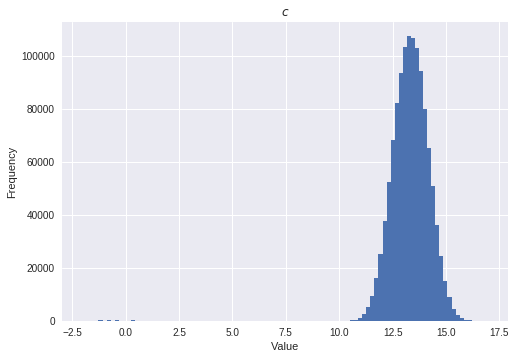

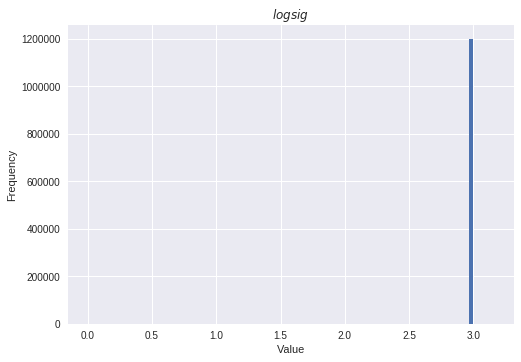

In [65]:
# Reset figure size
rc('figure', figsize=(8,5.5))

# Burn-in 20,000 iterations
nwalkers = 12
temp_pdset = pdset.copy()
pdset_burn = pdset[pdset.index >= 20000*nwalkers].copy()
pdset_burn = pdset_burn.reset_index(inplace=False)
pdset_burn = pdset_burn.drop('index', axis=1)

# Make histograms of MCMC chains post-burn-in
for par in [col for col in pdset_burn.columns if col not in ['LL', 'walker']]:
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.hist(pdset[par], bins=nbins)
    ax.set_title(eval('r"$'+par+'$"'))
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()

<h3> Chain Autocorrelation </h3>

<p>
Note that the implementation of chain autocorrelation below is a <a href="http://www.statsmodels.org/stable/index.html">statsmodels</a> function that is meant to be applied to univariate chains. Multivariate autocorrelation should be implemented here. For lack of time and caffeine, I use the univariate case for the sake of communicating the informativity of chain autocorrelation.
</p>

hist done
auto done
hist done
auto done
hist done
auto done
hist done
auto done


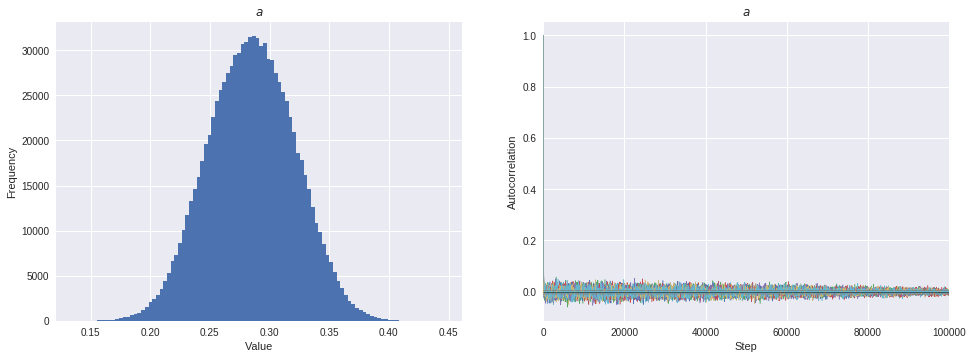

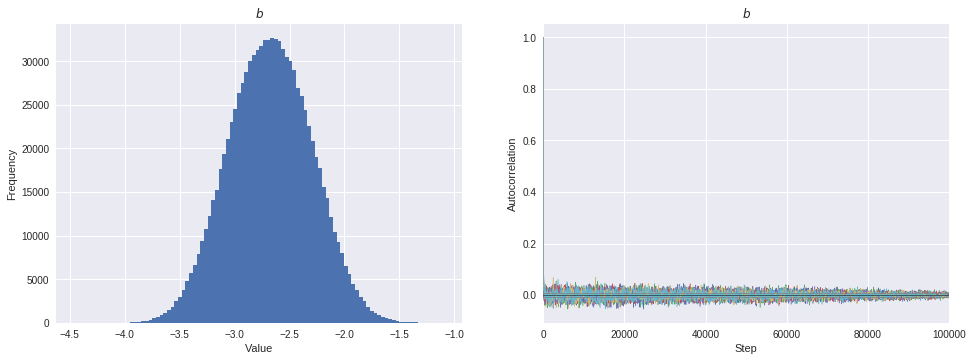

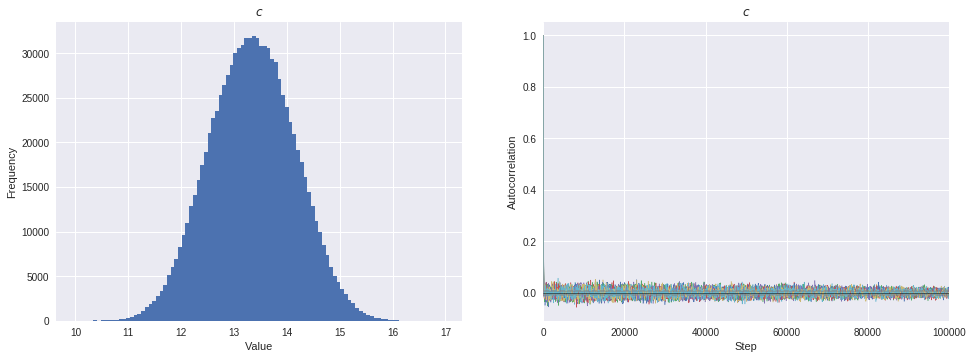

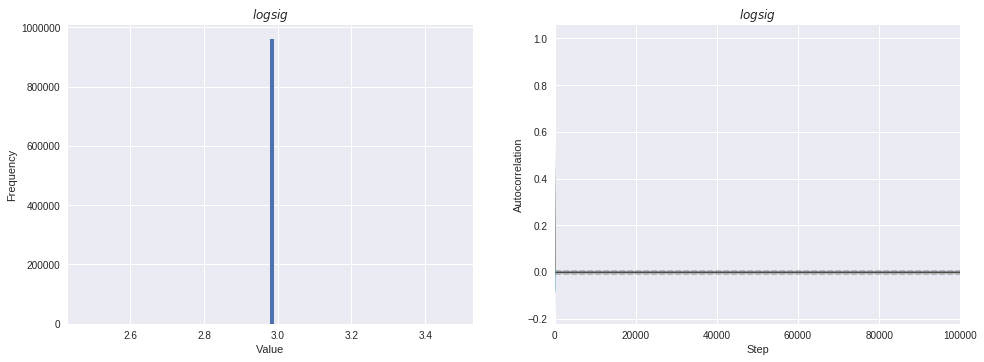

In [66]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=False)
rc('figure', figsize=(16,5.5))
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import acf

def plotAutoC(ax, dset, coll):
    """ Run the autocorrelation analysis and plot for the selected variable. """
    dset = pdset.copy()

    # Make the row something we can refer to
    dset['row'] = dset.index

    # Make a column for which step this came from within the walker
    dset['Step'] = dset.groupby('walker')['row'].rank()

    # Pivot to separate out all the walkers
    dd = dset.pivot(index='Step', columns='walker', values=coll)

    # Calculate the autocorrelation
    outt = dd.apply(lambda x: acf(x, nlags=x.size))

    # Plot the values
    outt.plot(ax=ax, legend=False, linewidth=0.5)
    ax.set_title(eval('r"$'+coll+'$"'))
    ax.set_ylabel('Autocorrelation')

    # Indicate the confidence intervals for failure
    z95 = 1.959963984540054 / np.sqrt(outt.shape[0])
    z99 = 2.5758293035489004 / np.sqrt(outt.shape[0])
    ax.axhline(y=z99, linestyle='--', color='grey', linewidth=0.5)
    ax.axhline(y=z95, color='grey', linewidth=0.5)
    ax.axhline(y=0.0, color='black', linewidth=0.5)
    ax.axhline(y=-z95, color='grey', linewidth=0.5)
    ax.axhline(y=-z99, linestyle='--', color='grey', linewidth=0.5)

# Number of bins for histogram
nbins = 100

# Get lists of walkers, parameter names
walkers = pdset['walker'].unique()
params = [col for col in pdset_burn.columns if col not in ['LL', 'walker']]

# List of matplotlib axes objects
axx = []

for j, par in enumerate(params):
    f = plt.figure()
    # Histogram
    axx.append(f.add_subplot(121))
    ax = axx[2*j]
    ax.hist(pdset_burn[par], bins=nbins)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(eval('r"$'+par+'$"'))
    print('hist done')
    # Autocorrelation plot
    axx.append(f.add_subplot(122))
    plotAutoC(axx[2*j+1], pdset_burn, par)
    print('auto done')
    
plt.show()

<h3> Chain Autocorrelation and Thinning </h3>

<p>
Note that in the above autocorrelation plots, only the logsig parameter's autocorrelation is below the safe statistical threshold (indicated by the dotted line), even after many iterations of the MCMC. This is due to an inherent property of Markov chains: each member of the chain is generated from a probability distribution dependent upon the previous member of the chain. For this reason, a common practice in MCMC implementations is <a href="http://onlinelibrary.wiley.com/doi/10.1111/j.2041-210X.2011.00131.x/epdf">thinning</a>\*, wherein one in every 100 or so element of the Markov Chain is saved. This significantly reduces chain autocorrelation. <br/> <br/>

\* Note that this paper, like the burn-in article, talks about thinning in the negative. Thinning, like burn-in, is not statistical malpractice; it's just not necessary. However, if implemented, it can serve as a metric of MCMC convergence.
</p>

<h4 style="color:red;"> STILL UNDER CONSTRUCTION </h4>

<h3> <a href="http://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/">Gelman-Rubin Convergence Diagnostic</a> </h3>

<p>
Note that PyMC3 has an implementations of the Gelman-Ruben diagnostic already built-in to the API. The page at the above hyperlink gives a concise description of how to apply the Gelman-Ruben diagnostic to a collection of univariate MCMC chains. For the multivariate case, which is implemented below, see <a href="http://www2.stat.duke.edu/~scs/Courses/Stat376/Papers/ConvergeDiagnostics/BrooksGelman.pdf">Brooks and Gelman</a>.
</p>

<h4 style="color:red;"> STILL UNDER CONSTRUCTION </h4>

<p style="color:red;">
"""
Define and implement Gelman-Ruben convergence diagnostic for multivariate chains, using the calculations described in the hyperlink above
"""

def grDiagnostic(pdset, params, walkers):
    """
    Takes in a Pandas dataframe corresponding to the output of the affine-invariant sampler; computes the Gelman-
    Ruben convergence diagnostic.
    """
    pset = pdset.copy()
    pset = pset.drop('LL', axis=1)
    walkers = pset['walker'].unique()
    params = [col for col in pset.columns if col != 'walker']
    m = len(walkers)
    n = len(params)
    for par in params:
        for wal in walker:
            temp = pset[pset['walker'] == wal]
            
            
    print(pset.columns)
grDiagnostic(pdset)

</p>

<h3> <a href="http://math.arizona.edu/~piegorsch/675/GewekeDiagnostics.pdf">Geweke Diagnostic</a> </h3>

<p>
Not implemented in this notebook. Another good test of MCMC convergence, described thoroughly in the hyperlinked presentation.
</p>

<h2> No U-Turn Sampler: a Powerful Hamiltonian MCMC</h2>

<p>
This is a very popular, fast, and well-documented MCMC. It is a Hamiltonian MCMC, which is a class of MCMCs that treat the likelihood of a point as that point's "potential energy." Hamiltonian MCMCs work by making the radius of a proposed move proportional to the opposite of the square of the potential energy of the current point. "NUTS" stands for "No U-Turn Sampler;" the implementation of gradient-based point proposals in the Markov Chain makes Hamiltonian MCMCs converge to their equilibrium distributions far faster than traditional MCMCs. While the number of iterations necessary for a traditional MCMC to converge to its equilibrium distribution scales exponentially with the number of parameters in the state-space, the number of iterations necessary for a Hamiltonian MCMC to converge scales linearly with the number of parameters in the state-space. <br/> <br/>

Because the NUTS sampler uses gradient methods to propose points in the Markov chain, it can only be implemented for models whose state spaces consist only of continuous variables. This means that NUTS cannot be wrapped around a log-likelihood function that implements an ODE solver; therefore, it is incompatible with PySB. Additionally, to make the MCMC much, much fast and able to deal with a plethora of continuous functions, the NUTS sampler is written to interface with Theano, a very sophisticated (and therefore difficult) numerical API. While NUTS should be preferred to just about any other MCMC implementation when the state-space is continuous, a NUTS sampler is a lot more difficult to set up than a sampler from the emcee package. <br/> <br/>

<a href="https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/api_quickstart.ipynb">Here</a> is a helpful quickstart guide for the PyMC3 API. This quickstart is so well-done that it would not be helpful to recreate an example implementation here.
</p>

In [14]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize']

[8.0, 5.5]

In [25]:
import numpy as np
import pandas as pd

a = np.random.rand(100,3)
b = pd.DataFrame(a)
b = b[b.index >= 10]
b.reset_index(inplace=True)
print(b)

    index         0         1         2
0      10  0.677305  0.600373  0.436148
1      11  0.109686  0.792486  0.271541
2      12  0.845638  0.504439  0.923577
3      13  0.823174  0.421719  0.465481
4      14  0.103759  0.695317  0.889944
5      15  0.749358  0.627332  0.865727
6      16  0.549649  0.531032  0.505301
7      17  0.025028  0.358891  0.782335
8      18  0.642231  0.871451  0.644831
9      19  0.766775  0.977893  0.227837
10     20  0.864938  0.677478  0.538265
11     21  0.569763  0.719907  0.665973
12     22  0.429592  0.469974  0.499518
13     23  0.745157  0.095468  0.691971
14     24  0.708016  0.947091  0.073202
15     25  0.914668  0.698471  0.958925
16     26  0.357479  0.471480  0.272334
17     27  0.153518  0.414411  0.843125
18     28  0.116365  0.505547  0.117094
19     29  0.606053  0.461833  0.511063
20     30  0.309680  0.152234  0.284662
21     31  0.413083  0.461932  0.768911
22     32  0.581155  0.863012  0.140208
23     33  0.409815  0.714295  0.926755
